In [77]:
import folktables
from folktables import ACSDataSource
import numpy as np

np.random.seed(0)
#(Age) must be greater than 16 and less than 90, and (Person weight) must be greater than or equal to 1
def employment_filter(data):
    """
    Filters for the employment prediction task
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df
ACSEmployment = folktables.BasicProblem(
    features=[
       'AGEP', #age; for range of values of features please check Appendix B.4 of
           #Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
       'SCHL', #educational attainment
       'MAR', #marital status
       'RELP', #relationship
       'DIS', #disability recode
       'ESP', #employment status of parents
       'CIT', #citizenship status
       'MIG', #mobility status (lived here 1 year ago)
       'MIL', #military service
       'ANC', #ancestry recode
       'NATIVITY', #nativity
       'DEAR', #hearing difficulty
       'DEYE', #vision difficulty
       'DREM', #cognitive difficulty
       'SEX', #sex
       'RAC1P', #recoded detailed race code
       'GCL', #grandparents living with grandchildren
    ],
    target='ESR', #employment status recode
    target_transform=lambda x: x == 1,
    group='DIS',
    preprocess=employment_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["FL"], download=True) #data for Florida state
features, label, group = ACSEmployment.df_to_numpy(acs_data)

In [78]:
from aif360.datasets import StandardDataset
import pandas as pd
data = pd.DataFrame(features, columns = ACSEmployment.features)
data['label'] = label
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])
data_for_aif = StandardDataset(data, 'label', favorable_classes = favorable_classes,
                      protected_attribute_names = protected_attribute_names,
                      privileged_classes = privileged_classes)
privileged_groups = [{'DIS': 1}]
unprivileged_groups = [{'DIS': 2}]

/Users/Kotsi/Desktop/AI_Imperial/Ethics/Fairness-ML/my_env/lib/python3.11/site-packages/aif360/datasets/standard_dataset.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[pos, label_name] = favorable_label


### Task 1(a) - Split data

In [79]:
data_size = data_for_aif.features.shape[0]
train, test = data_for_aif.split([0.7], shuffle=True)
splits = []
for _ in range(5):
    train, val = train.split([0.8], shuffle=True)
    splits.append((train, val))

In [80]:
train.features.shape

(38374, 17)

### Task 1(b) - Model selection

In [81]:
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression


def find_most_accurate_logistic_reg_model(splits, parameters, reweighing=False):
    mean_accuracies = []
    final_scaler = None
    max_accuracy = -float('inf')
    best_model = None
    for parameter in parameters:
        accuracies = []
        for train, val in splits:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(train.features)
            y_train = train.labels.ravel()

            X_val = scaler.transform(val.features)
            y_val = val.labels.ravel()
            learner = LogisticRegression(C=parameter, solver='liblinear', random_state=1)
            if reweighing:
                RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

                train = RW.fit_transform(train)
                learner.fit(X_train, y_train, sample_weight=train.instance_weights)
            else:
                learner.fit(X_train, y_train)   
            predictions = learner.predict(X_val)
            accuracy = sum((predictions==y_val) / len(y_val))
            accuracies.append(accuracy)
        mean_accuracy = sum(accuracies) / len(accuracies)
        #print(mean_accuracy)
        mean_accuracies.append(mean_accuracy)
        if mean_accuracy > max_accuracy:
            max_accuracy = mean_accuracy
            best_model = learner
            final_scaler = scaler
    return best_model, final_scaler, max_accuracy, parameters, mean_accuracies



In [82]:
parameters = [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
final_model, final_scaler, final_accuracy, parameters, mean_accuracies = find_most_accurate_logistic_reg_model(splits=splits, parameters=parameters)
for i,j in zip(parameters, mean_accuracies):
    print(f"C={i}      Accuracy={j}")

C=1e-09      Accuracy=0.7278732926752216
C=1e-08      Accuracy=0.7278818312911118
C=1e-07      Accuracy=0.7279406012475123
C=1e-06      Accuracy=0.7283289969084796
C=1e-05      Accuracy=0.7314863885593151
C=0.0001      Accuracy=0.7406417952359189
C=0.001      Accuracy=0.7504557973171282
C=0.01      Accuracy=0.7510436551156963
C=0.1      Accuracy=0.751333899988068
C=1      Accuracy=0.7512453126883355
C=10      Accuracy=0.7512559856164533
C=100      Accuracy=0.751272662011017


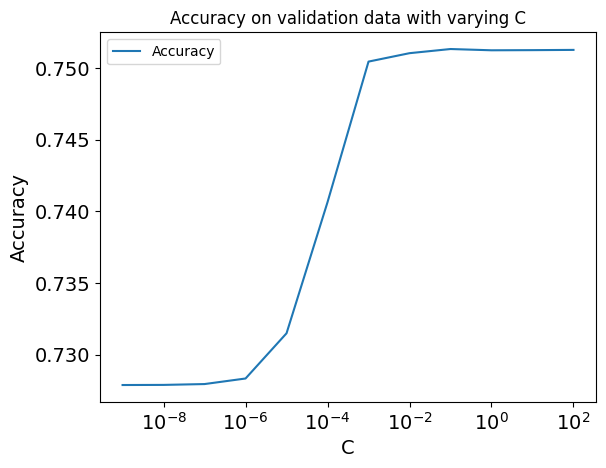

In [83]:
import matplotlib.pyplot as plt
plt.rc('axes', titlesize='large')    # Default is typically 'large'
plt.rc('axes', labelsize='medium')   # Default is 'medium'
plt.rc('xtick', labelsize='medium')  # Default is 'medium'
plt.rc('ytick', labelsize='medium')  # Default is 'medium'
plt.rc('legend', fontsize='medium')  # Default is 'medium'


plt.plot(parameters, mean_accuracies, label='Accuracy') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Accuracy on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Accuracy', fontsize=14)     

plt.legend()
#plt.savefig("non-pre_accuracy.png", dpi=600)
plt.show()

In [84]:
print(f"Final Model: {final_model}\n")
print(f"Final Scaler: {final_scaler}\n")
print(f"Final Mean Accuracy on Val data : {final_accuracy}")

Final Model: LogisticRegression(C=0.1, random_state=1, solver='liblinear')

Final Scaler: StandardScaler()

Final Mean Accuracy on Val data : 0.751333899988068


### Test the final model on test data

In [85]:
from aif360.metrics import ClassificationMetric

def test_model_on_unseen_data(final_scaler, test, final_model, unprivileged_groups, privileged_groups):
    X_test = final_scaler.transform(test.features)
    y_test = test.labels.ravel()

    test_predictions = final_model.predict(X_test)

    test_pred = test.copy()
    test_pred.labels = test_predictions

    test_accuracy = sum((test_predictions == y_test) / len(y_test))

    metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    eq_opp_diff = metric.equal_opportunity_difference()

    return test_accuracy, eq_opp_diff

In [86]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

### Final accuracy and fairness on test data

In [87]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7534268409311323

Fairness on test data using the equal opportunity difference metric: 0.6253460276847063


### Task(c) - Model selection based on fairness

In [88]:
def find_most_fair_logistic_reg_model(splits, parameters, reweighing=False):
    mean_fearnesses = []
    mean_fairnesses_abs = []
    final_scaler = None
    min_diff = float('inf')
    best_model = None
    for parameter in parameters:
        fairnesses = []
        fairnesses_abs = []
        for train, val in splits:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(train.features)
            y_train = train.labels.ravel()

            X_val = scaler.transform(val.features)
            y_val = val.labels.ravel()
            learner = LogisticRegression(C=parameter, solver='liblinear', random_state=1)
            if reweighing:
                RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

                train = RW.fit_transform(train)
                learner.fit(X_train, y_train, sample_weight=train.instance_weights)
            else:
                learner.fit(X_train, y_train)  
            predictions = learner.predict(X_val)
            
            val_pred = val.copy()
            val_pred.labels = predictions
            metric = ClassificationMetric(val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
            fairness = metric.equal_opportunity_difference()
            fairnesses.append(fairness)
            fairness_abs = abs(metric.equal_opportunity_difference())
            fairnesses_abs.append(fairness_abs)
        mean_fairness = sum(fairnesses) / len(fairnesses)
        mean_fearnesses.append(mean_fairness)
        mean_fairness_abs = sum(fairnesses_abs) / len(fairnesses_abs)
        mean_fairnesses_abs.append(mean_fairness_abs)
        #print(mean_fairness)
        if mean_fairness_abs < min_diff:
            min_diff = mean_fairness_abs
            best_model = learner
            final_scaler = scaler
    return best_model, final_scaler, min_diff, parameters, mean_fairnesses_abs, mean_fearnesses

In [89]:
final_model, final_scaler, final_fairness, parameters, mean_fairnesses_abs, mean_fairnesses = find_most_fair_logistic_reg_model(splits = splits, parameters=parameters)

for parameter, fairness in zip(parameters, mean_fairnesses):
    print(f"C={parameter}    Fairness={fairness}")

C=1e-09    Fairness=0.874886459952592
C=1e-08    Fairness=0.8746386289856005
C=1e-07    Fairness=0.8745775633212449
C=1e-06    Fairness=0.8747863909702203
C=1e-05    Fairness=0.8699089357627525
C=0.0001    Fairness=0.8120097202672115
C=0.001    Fairness=0.6806798486863179
C=0.01    Fairness=0.6288675448156403
C=0.1    Fairness=0.619378386471738
C=1    Fairness=0.6179080169947406
C=10    Fairness=0.6179080169947406
C=100    Fairness=0.6179080169947406


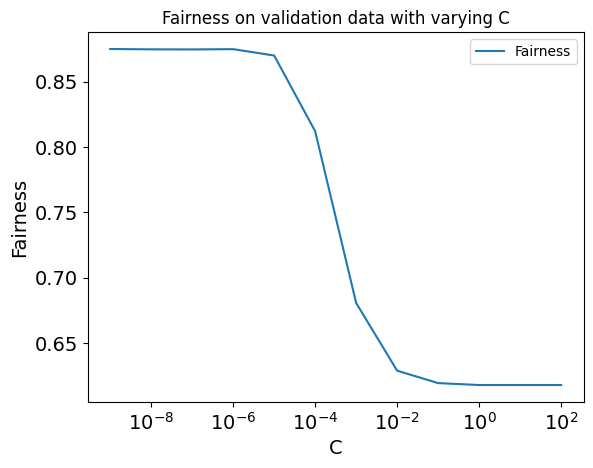

In [90]:
import matplotlib.pyplot as plt

plt.plot(parameters, mean_fairnesses_abs, label='Fairness') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Fairness on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Fairness', fontsize=14)     

plt.legend()
#plt.savefig("non-pre_fairness.png", dpi=600)
plt.show()

### Test the final model on test data

In [91]:
final_model

LogisticRegression(C=1, random_state=1, solver='liblinear')

In [92]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

### Final accuracy and fairness on test data

In [93]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7531678355119419

Fairness on test data using the equal opportunity difference metric: 0.6227677730313754


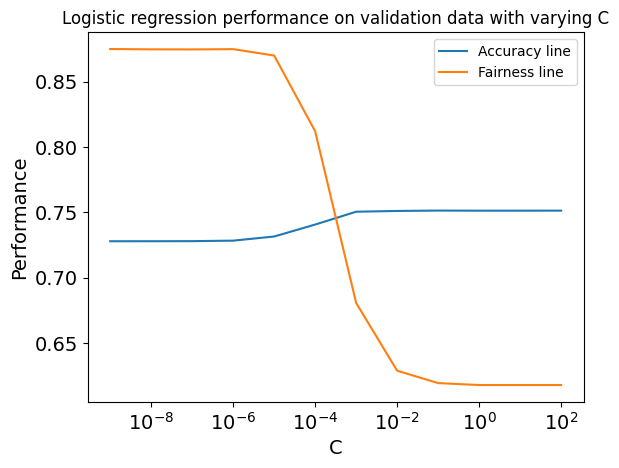

In [94]:
import matplotlib.pyplot as plt

plt.plot(parameters, mean_accuracies, label='Accuracy line') 
plt.plot(parameters, mean_fairnesses, label='Fairness line')
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression performance on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Performance',fontsize=14)     

plt.legend()
#plt.savefig("non-pre_performance.png", dpi=600)
plt.show()

### Task 2(a) - Select the most accurate model after reweighing

In [95]:
from aif360.algorithms.preprocessing.reweighing import Reweighing

final_model, final_scaler, final_accuracy, parameters, mean_accuracies = find_most_accurate_logistic_reg_model(splits=splits, parameters=parameters, reweighing=True)

for parameter, accuracy in zip(parameters, mean_accuracies):
    print(f"C={parameter}     Accuracy={accuracy}")

C=1e-09     Accuracy=0.7060876934769293
C=1e-08     Accuracy=0.7060924961991752
C=1e-07     Accuracy=0.7061784150888892
C=1e-06     Accuracy=0.7065003758759009
C=1e-05     Accuracy=0.7097856538955817
C=0.0001     Accuracy=0.7183906695568629
C=0.001     Accuracy=0.7207855362537557
C=0.01     Accuracy=0.7205984845048118
C=0.1     Accuracy=0.7205211668294151
C=1     Accuracy=0.7203790822835446
C=10     Accuracy=0.7203838850057905
C=100     Accuracy=0.7204047313681003


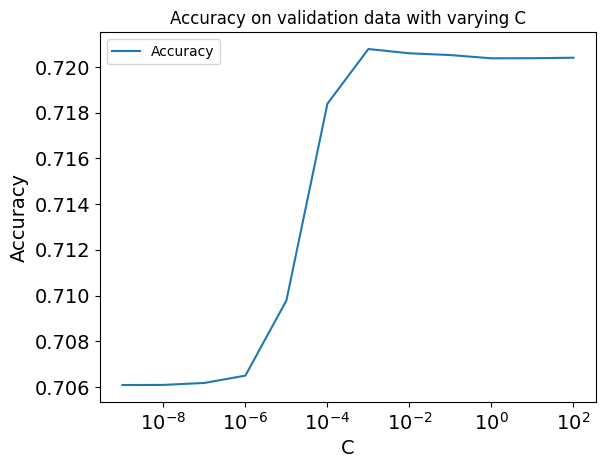

In [96]:
plt.plot(parameters, mean_accuracies, label='Accuracy') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Accuracy on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Accuracy', fontsize=14)     

plt.legend()
#plt.savefig("pre_accuracy.png", dpi=600)
plt.show()

In [97]:
final_model

LogisticRegression(C=0.001, random_state=1, solver='liblinear')

### Test the most accurate model after reweighting on the test data

In [98]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

### Final accuracy and fairness on test data after reweighing

In [99]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7202143767934045

Fairness on test data using the equal opportunity difference metric: 0.018399325005312384


### Task 2(b) - Select the most fair model after reweighing

In [100]:
final_model, final_scaler, final_fairness, parameters, mean_fairnesses_abs, mean_fairnesses= find_most_fair_logistic_reg_model(splits=splits, parameters=parameters, reweighing=True)

for parameter, fairness in zip(parameters, mean_fairnesses):
    print(f"C={parameter}    Fairness={fairness}")

C=1e-09    Fairness=0.18490624114926552
C=1e-08    Fairness=0.1849328121602925
C=1e-07    Fairness=0.18319956070497184
C=1e-06    Fairness=0.17784120521850805
C=1e-05    Fairness=0.1371619421679441
C=0.0001    Fairness=0.03338916904837878
C=0.001    Fairness=-0.017429445800923003
C=0.01    Fairness=-0.02739837425851599
C=0.1    Fairness=-0.028217586707294084
C=1    Fairness=-0.028153165256169378
C=10    Fairness=-0.028110154524476495
C=100    Fairness=-0.028110154524476495


In [101]:
final_model

LogisticRegression(C=0.001, random_state=1, solver='liblinear')

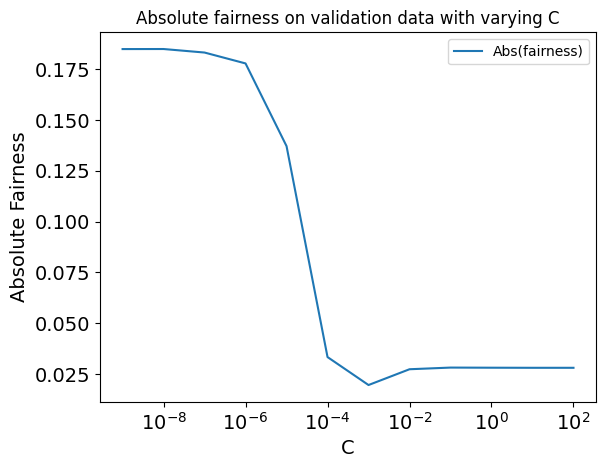

In [102]:
plt.plot(parameters, mean_fairnesses_abs, label='Abs(fairness)') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Absolute fairness on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Absolute Fairness', fontsize=14)     


plt.legend()
#plt.savefig("pre_fairness.png", dpi=600)
plt.show()

### Test the most fair model after reweighting on the test data

In [103]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

### Final accuracy and fairness on test data after reweighing

In [104]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7202143767934045

Fairness on test data using the equal opportunity difference metric: 0.018399325005312384


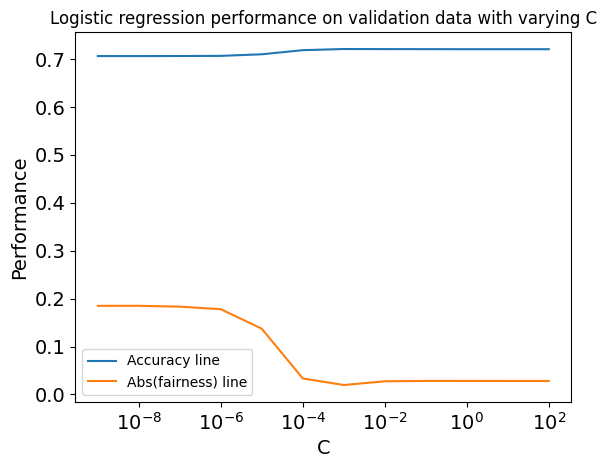

In [105]:
plt.plot(parameters, mean_accuracies, label='Accuracy line') 
plt.plot(parameters, mean_fairnesses_abs, label='Abs(fairness) line')
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression performance on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Performance', fontsize=14)     

plt.legend()
plt.savefig("pre_performance.png", dpi=600)
plt.show()

### Task 3(a) Find best standard model

In [106]:
def find_best_model(splits, parameters, reweighing=False, accuracy_weight=0.5, fairness_weight=0.5):
    mean_combined_metrics = []
    final_scaler = None
    max_ = -float('inf')
    best_model = None
    for parameter in parameters:
        combined_metrics = []
        for train, val in splits:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(train.features)
            y_train = train.labels.ravel()

            X_val = scaler.transform(val.features)
            y_val = val.labels.ravel()
            learner = LogisticRegression(C=parameter, solver='liblinear', random_state=1)
            if reweighing:
                RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

                train = RW.fit_transform(train)
                learner.fit(X_train, y_train, sample_weight=train.instance_weights)
            else:
                learner.fit(X_train, y_train)  
            predictions = learner.predict(X_val)
            

            accuracy = sum((predictions == y_val) / len(y_val) )
            
            val_pred = val.copy()
            val_pred.labels = predictions
            metric = ClassificationMetric(val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
            fairness_abs = abs(metric.equal_opportunity_difference())
            combined_metric = accuracy_weight * accuracy + fairness_weight * (1 - fairness_abs)
            combined_metrics.append(combined_metric)
        mean_combined_metric = sum(combined_metrics) / len(combined_metrics)
        mean_combined_metrics.append(mean_combined_metric)
        #print(mean_fairness)
        if mean_combined_metric > max_:
            max_ = mean_combined_metric
            best_model = learner
            final_scaler = scaler
    return best_model, final_scaler, max_, parameters, mean_combined_metrics, accuracy_weight, fairness_weight

In [107]:
final_model, final_scaler, max_, parameters, mean_combined_metrics, accuracy_weight, fairness_weight = find_best_model(splits=splits, parameters=parameters, accuracy_weight=0.25, fairness_weight=0.75)
for parameter, combined_metric in zip(parameters, mean_combined_metrics):
    print(f"C={parameter}    Combined metric={combined_metric}")

C=1e-09    Combined metric=0.2758034782043614
C=1e-08    Combined metric=0.27599148608357754
C=1e-07    Combined metric=0.27605197782094437
C=1e-06    Combined metric=0.27599245599945477
C=1e-05    Combined metric=0.2804398953177644
C=0.0001    Combined metric=0.3261531586085712
C=0.001    Combined metric=0.4271040628145436
C=0.01    Combined metric=0.4661102551671939
C=0.1    Combined metric=0.47329968514321347
C=1    Combined metric=0.47438031542602843
C=10    Combined metric=0.47438298365805787
C=100    Combined metric=0.4743871527566988


In [108]:
final_model, max_

(LogisticRegression(C=100, random_state=1, solver='liblinear'),
 0.4743871527566988)

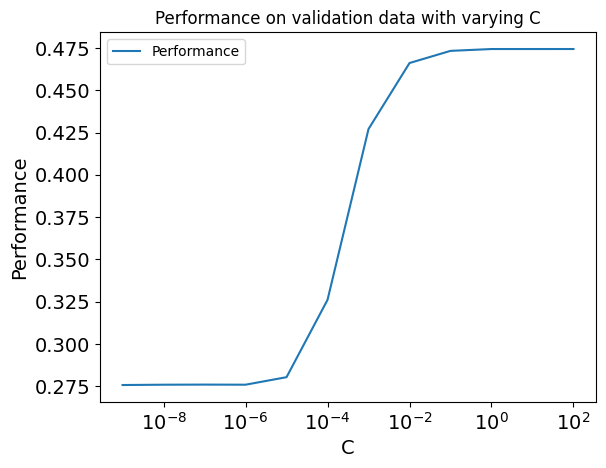

In [109]:
plt.plot(parameters, mean_combined_metrics, label='Performance') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Performance on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Performance', fontsize=14)     

plt.legend()



plt.show()

In [110]:
accuracy_weight, fairness_weight


(0.25, 0.75)

In [111]:
def test_model_on_unseen_data_weighted(final_scaler, test, final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, accuracy_weight=0.5, fairness_weight=0.5):
    X_test = final_scaler.transform(test.features)
    y_test = test.labels.ravel()

    test_predictions = final_model.predict(X_test)

    test_pred = test.copy()
    test_pred.labels = test_predictions

    test_accuracy = sum((test_predictions == y_test) / len(y_test))

    metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    eq_opp_diff = abs(metric.equal_opportunity_difference())
    
    combined_metric = accuracy_weight * test_accuracy + fairness_weight * (1-eq_opp_diff)

    return combined_metric


In [112]:
test_combined_metric = test_model_on_unseen_data_weighted(final_scaler=final_scaler, test=test, final_model=final_model, accuracy_weight=0.25, fairness_weight=0.75)

In [113]:
print(f"Final combined metric of best model on unseen data: {test_combined_metric}")

Final combined metric of best model on unseen data: 0.47119092160243703


### Task 3(b)

In [114]:
final_model, final_scaler, max_, parameters, mean_combined_metrics, accuracy_weight, fairness_weight = find_best_model(splits=splits, parameters=parameters, reweighing=True, accuracy_weight=0.75, fairness_weight=0.25)

for parameter, combined_metric in zip(parameters, mean_combined_metrics):
    print(f"C={parameter}    Combined Metric={combined_metric}")

C=1e-09    Combined Metric=0.7333392098203806
C=1e-08    Combined Metric=0.7333361691093082
C=1e-07    Combined Metric=0.7338339211404239
C=1e-06    Combined Metric=0.7354149806022987
C=1e-05    Combined Metric=0.7480487548797001
C=0.0001    Combined Metric=0.7804457099055524
C=0.001    Combined Metric=0.7856799505536944
C=0.01    Combined Metric=0.7835992698139798
C=0.1    Combined Metric=0.7833364784452378
C=1    Combined Metric=0.7832460203986161
C=10    Combined Metric=0.7832603751232238
C=100    Combined Metric=0.7832760098949562


In [115]:
final_model, max_

(LogisticRegression(C=0.001, random_state=1, solver='liblinear'),
 0.7856799505536944)

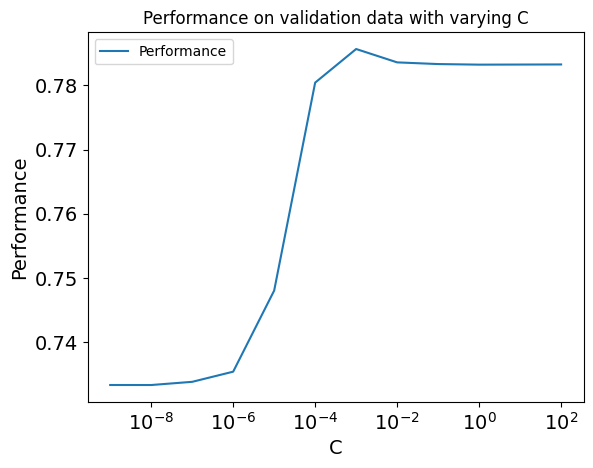

In [116]:
plt.plot(parameters, mean_combined_metrics, label='Performance') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Performance on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Performance', fontsize=14)     

plt.legend()
#plt.savefig("_pre_performance_.png", dpi=600)
plt.show()

In [117]:
test_combined_metric = test_model_on_unseen_data_weighted(final_scaler=final_scaler, test=test, final_model=final_model, accuracy_weight=0.75, fairness_weight=0.25)

In [118]:
print(f"Final combined metric of best model on unseen data: {test_combined_metric}")

Final combined metric of best model on unseen data: 0.7855609513437253


## Extra Section : Perform model selection on data for Florida state (states=[”FL”]), while test on data for Texas (states=[”TX”]). Analyse how this change the performance of the models 1-6.

### Split the Florida state data into 5 random splits 0.7/0.3 

In [119]:
splits = []
for _ in range(5):
    train, val = data_for_aif.split([0.7], shuffle=True)
    splits.append((train, val))

In [120]:
acs_data = data_source.get_data(states=["TX"], download=True) #data for Texas state
features, label, group = ACSEmployment.df_to_numpy(acs_data)

In [121]:
data = pd.DataFrame(features, columns = ACSEmployment.features)
data['label'] = label
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])
data_for_aif = StandardDataset(data, 'label', favorable_classes = favorable_classes,
                      protected_attribute_names = protected_attribute_names,
                      privileged_classes = privileged_classes)
privileged_groups = [{'DIS': 1}]
unprivileged_groups = [{'DIS': 2}]


/Users/Kotsi/Desktop/AI_Imperial/Ethics/Fairness-ML/my_env/lib/python3.11/site-packages/aif360/datasets/standard_dataset.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[pos, label_name] = favorable_label


In [122]:
test = data_for_aif
test.features.shape

(208358, 17)

### Model 1

In [123]:
final_model, final_scaler, final_accuracy, parameters, mean_accuracies = find_most_accurate_logistic_reg_model(splits=splits, parameters=parameters)
for i,j in zip(parameters, mean_accuracies):
    print(f"C={i}      Accuracy={j}")

C=1e-09      Accuracy=0.7270959515463566
C=1e-08      Accuracy=0.7271158750401405
C=1e-07      Accuracy=0.7272433854003573
C=1e-06      Accuracy=0.7279885240678744
C=1e-05      Accuracy=0.7329853363088714
C=0.0001      Accuracy=0.7453179789610932
C=0.001      Accuracy=0.7525781000959391
C=0.01      Accuracy=0.7525741153971823
C=0.1      Accuracy=0.7524386356394519
C=1      Accuracy=0.7524226968444248
C=10      Accuracy=0.752418712145668
C=100      Accuracy=0.752418712145668


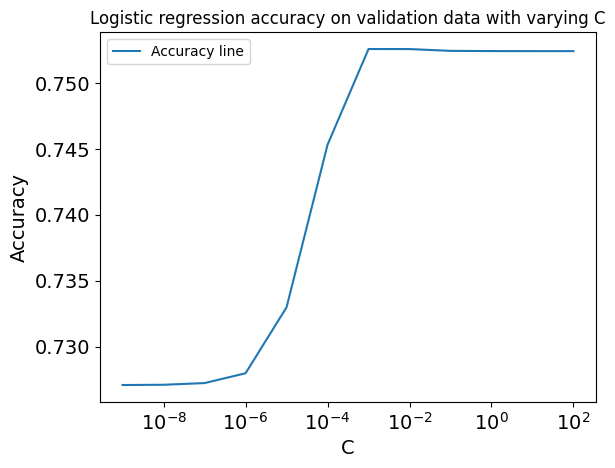

In [124]:
import matplotlib.pyplot as plt
plt.rc('axes', titlesize='large')    # Default is typically 'large'
plt.rc('axes', labelsize='medium')   # Default is 'medium'
plt.rc('xtick', labelsize='medium')  # Default is 'medium'
plt.rc('ytick', labelsize='medium')  # Default is 'medium'
plt.rc('legend', fontsize='medium')  # Default is 'medium'


plt.plot(parameters, mean_accuracies, label='Accuracy line') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression accuracy on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Accuracy', fontsize=14)     

plt.legend()
#plt.savefig("non-pre_accuracy.png", dpi=600)
plt.show()

In [125]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

In [126]:
final_model

LogisticRegression(C=0.001, random_state=1, solver='liblinear')

In [127]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7322109062281867

Fairness on test data using the equal opportunity difference metric: 0.6453742669061344


### Model 2

In [128]:
final_model, final_scaler, final_fairness, parameters, mean_fairnesses_abs, mean_fairnesses = find_most_fair_logistic_reg_model(splits = splits, parameters=parameters)

for parameter, fairness in zip(parameters, mean_fairnesses):
    print(f"C={parameter}    Fairness={fairness}")

C=1e-09    Fairness=0.8726581665545794
C=1e-08    Fairness=0.8726662300952801
C=1e-07    Fairness=0.8727625430107586
C=1e-06    Fairness=0.8717626031039879
C=1e-05    Fairness=0.8627254037458363
C=0.0001    Fairness=0.7816753829663817
C=0.001    Fairness=0.6606788071276174
C=0.01    Fairness=0.6275850570513105
C=0.1    Fairness=0.6252239848156078
C=1    Fairness=0.6246314959692666
C=10    Fairness=0.6246314475655029
C=100    Fairness=0.6246314475655029


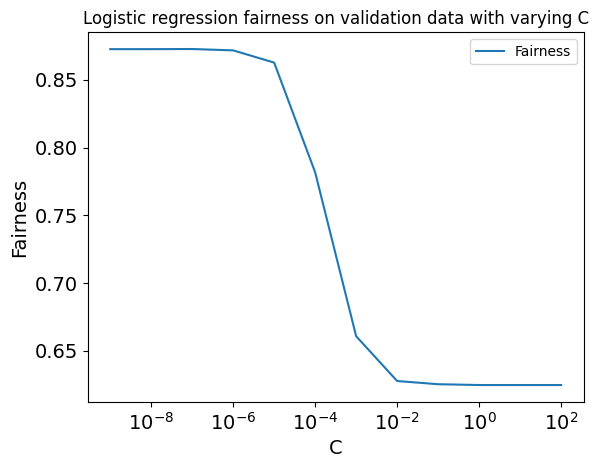

In [129]:
import matplotlib.pyplot as plt

plt.plot(parameters, mean_fairnesses_abs, label='Fairness') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression fairness on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Fairness', fontsize=14)     

plt.legend()
#plt.savefig("non-pre_fairness.png", dpi=600)
plt.show()

In [130]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

In [131]:
final_model

LogisticRegression(C=10, random_state=1, solver='liblinear')

In [132]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.7320861210027583

Fairness on test data using the equal opportunity difference metric: 0.6060792127688454


### Model 3

In [133]:
final_model, final_scaler, final_accuracy, parameters, mean_accuracies = find_most_accurate_logistic_reg_model(splits=splits, parameters=parameters, reweighing=True)

for parameter, accuracy in zip(parameters, mean_accuracies):
    print(f"C={parameter}     Accuracy={accuracy}")

C=1e-09     Accuracy=0.7076346828182627
C=1e-08     Accuracy=0.707646636914533
C=1e-07     Accuracy=0.7077781319735067
C=1e-06     Accuracy=0.7084635001596721
C=1e-05     Accuracy=0.7126474338542869
C=0.0001     Accuracy=0.7197840293276727
C=0.001     Accuracy=0.7201028052282148
C=0.01     Accuracy=0.719867708001565
C=0.1     Accuracy=0.7199872489642682
C=1     Accuracy=0.7199992030605386
C=10     Accuracy=0.7200151418555658
C=100     Accuracy=0.7200151418555658


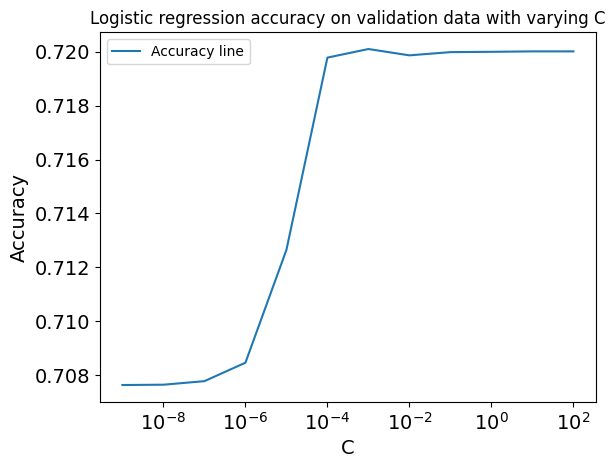

In [134]:
plt.plot(parameters, mean_accuracies, label='Accuracy line') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression accuracy on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Accuracy', fontsize=14)     

plt.legend()
plt.savefig("pre_accuracy.png", dpi=600)
plt.show()

In [135]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

In [136]:
final_model

LogisticRegression(C=0.001, random_state=1, solver='liblinear')

In [137]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.6997859453437736

Fairness on test data using the equal opportunity difference metric: 0.007641230072841565


### Model 4

In [138]:
final_model, final_scaler, final_fairness, parameters, mean_fairnesses_abs, mean_fairnesses= find_most_fair_logistic_reg_model(splits=splits, parameters=parameters, reweighing=True)

for parameter, fairness in zip(parameters, mean_fairnesses):
    print(f"C={parameter}    Fairness={fairness}")

C=1e-09    Fairness=0.17870330783005883
C=1e-08    Fairness=0.1787435771394989
C=1e-07    Fairness=0.1783426821152667
C=1e-06    Fairness=0.168336400528795
C=1e-05    Fairness=0.10802541966358412
C=0.0001    Fairness=0.01643761436295905
C=0.001    Fairness=-0.012711354451374723
C=0.01    Fairness=-0.01711902183706233
C=0.1    Fairness=-0.018260638324354695
C=1    Fairness=-0.018236583794529547
C=10    Fairness=-0.018164054293019392
C=100    Fairness=-0.018164054293019392


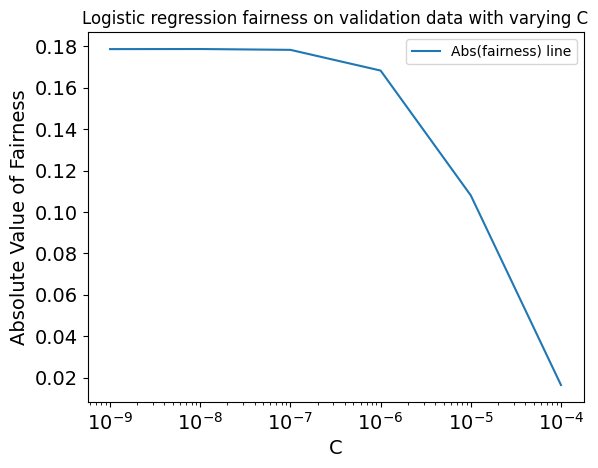

In [139]:
plt.plot(parameters[:6], mean_fairnesses_abs[:6], label='Abs(fairness) line') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression fairness on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Absolute Value of Fairness', fontsize=14)     

plt.legend()
plt.savefig("pre_fairness.png", dpi=600)
plt.show()

In [140]:
test_accuracy, eq_opp_diff = test_model_on_unseen_data(final_scaler=final_scaler, test=test, final_model=final_model, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

In [141]:
final_model

LogisticRegression(C=0.001, random_state=1, solver='liblinear')

In [142]:
print(f"Final accuracy on test data: {test_accuracy}\n")
print(f"Fairness on test data using the equal opportunity difference metric: {eq_opp_diff}")

Final accuracy on test data: 0.6997859453437736

Fairness on test data using the equal opportunity difference metric: 0.007641230072841565


### Model 5

In [143]:
final_model, final_scaler, max_, parameters, mean_combined_metrics, accuracy_weight, fairness_weight = find_best_model(splits=splits, parameters=parameters, accuracy_weight=0.25, fairness_weight=0.75)
for parameter, combined_metric in zip(parameters, mean_combined_metrics):
    print(f"C={parameter}    Combined metric={combined_metric}")

C=1e-09    Combined metric=0.2772803629706546
C=1e-08    Combined metric=0.27727929618857505
C=1e-07    Combined metric=0.27723893909202035
C=1e-06    Combined metric=0.2781751786889776
C=1e-05    Combined metric=0.2862022812678407
C=0.0001    Combined metric=0.35007295751548695
C=0.001    Combined metric=0.4426354196782717
C=0.01    Combined metric=0.46745473606081267
C=0.1    Combined metric=0.46919167029815706
C=1    Combined metric=0.46963205223415627
C=10    Combined metric=0.4696310923622898
C=100    Combined metric=0.4696310923622898


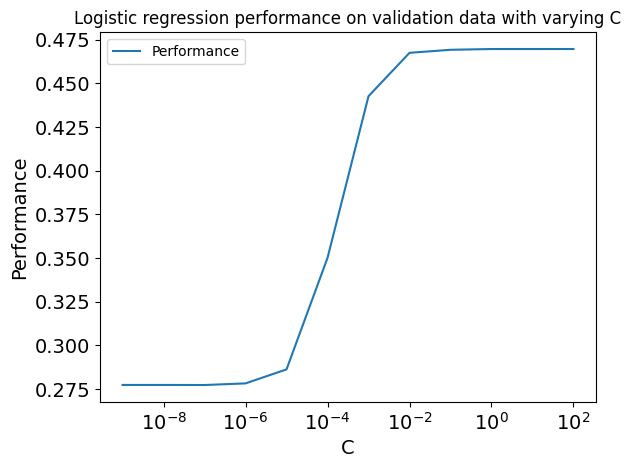

In [144]:
plt.plot(parameters, mean_combined_metrics, label='Performance') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression performance on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Performance', fontsize=14)     


plt.legend()



plt.show()

In [145]:
test_combined_metric = test_model_on_unseen_data_weighted(final_scaler=final_scaler, test=test, final_model=final_model, accuracy_weight=0.25, fairness_weight=0.75)

In [146]:
final_model

LogisticRegression(C=1, random_state=1, solver='liblinear')

In [147]:
print(f"Final combined metric of best model on unseen data: {test_combined_metric}")

Final combined metric of best model on unseen data: 0.4784542790045868


In [148]:
final_model, final_scaler, max_, parameters, mean_combined_metrics, accuracy_weight, fairness_weight = find_best_model(splits=splits, parameters=parameters, reweighing=True, accuracy_weight=0.75, fairness_weight=0.25)

for parameter, combined_metric in zip(parameters, mean_combined_metrics):
    print(f"C={parameter}    Combined Metric={combined_metric}")

C=1e-09    Combined Metric=0.7360501851561823
C=1e-08    Combined Metric=0.736049083401025
C=1e-07    Combined Metric=0.7362479284513134
C=1e-06    Combined Metric=0.7392635249875552
C=1e-05    Combined Metric=0.7574792204748191
C=0.0001    Combined Metric=0.7857286184050147
C=0.001    Combined Metric=0.7868992653083173
C=0.01    Combined Metric=0.7856210255419083
C=0.1    Combined Metric=0.7854252771421125
C=1    Combined Metric=0.7854402563467715
C=10    Combined Metric=0.7854703428184194
C=100    Combined Metric=0.7854703428184194


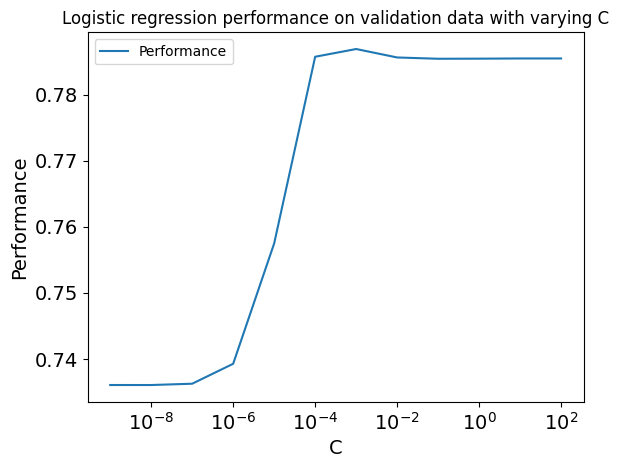

In [149]:
plt.plot(parameters, mean_combined_metrics, label='Performance') 
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Logistic regression performance on validation data with varying C')        
plt.xlabel('C', fontsize=14)     
plt.ylabel('Performance', fontsize=14)     

plt.legend()
#plt.savefig("_pre_performance_.png", dpi=600)
plt.show()

In [150]:
test_combined_metric = test_model_on_unseen_data_weighted(final_scaler=final_scaler, test=test, final_model=final_model, accuracy_weight=0.75, fairness_weight=0.25)

In [151]:
final_model

LogisticRegression(C=0.001, random_state=1, solver='liblinear')

In [152]:
print(f"Final combined metric of best model on unseen data: {test_combined_metric}")

Final combined metric of best model on unseen data: 0.7729291514896198
